# Data prepare 

This segment prepares dataset containig normalized sound recordings extended with temperature and humidity values. For now we support only one hive for data preparation.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# 1300001 - hive
# 1300002 - not hive?
# 1400001 - hive szymanski
# 1400002 - hive szymanski
#hives_ids = [1300001, 1300002, 1400001, 1400002]

hives_ids = [1300001]
DATA_INIT = True

In [3]:
if DATA_INIT:
    dfh_hives = [pd.read_csv(f"measurements/{hive_id}/humidity.csv") for hive_id in hives_ids]
    dft_hives = [pd.read_csv(f"measurements/{hive_id}/temperature.csv") for hive_id in hives_ids]
    dfh_hivesWithoutDuplicates = [dfh_hive.drop_duplicates(subset=['timestamp'], keep=False) for dfh_hive in dfh_hives]
    dft_hivesWithoutDuplicates = [dft_hive.drop_duplicates(subset=['timestamp'], keep=False) for dft_hive in dft_hives]

    for idx, hive_id in enumerate(hives_ids):
        print(f"Hive no. {hives_ids[idx]} | humidity temperature dataset size : {dfh_hivesWithoutDuplicates[idx].shape} {dft_hivesWithoutDuplicates[idx].shape}")

    df_hive = [pd.merge(
        dfh_hivesWithoutDuplicates[idx], dft_hivesWithoutDuplicates[idx], on='timestamp', suffixes=(f"_humidity_{hive_id}",f"_temperature_{hive_id}"))
               for idx, hive_id in enumerate(hives_ids)]

    
    total = 0
    for atmosphere_data in df_hive:
        atmosphere_data['timestamp'] = pd.to_datetime(atmosphere_data['timestamp'], format='%Y-%m-%dT%H-%M-%S').sort_values()
        atmosphere_data.set_index('timestamp', inplace=True)
        print(f"Atmospheric data after merge: {atmosphere_data.shape}")
        total += atmosphere_data.shape[0]
    
    print(f"Total atmoshpere dataset size: {total}")

Hive no. 1300001 | humidity temperature dataset size : (6776, 2) (6786, 2)
Atmospheric data after merge: (6696, 2)
Total atmoshpere dataset size: 6696


In [31]:
import glob
from scipy.fftpack import rfft
from scipy.signal import blackman
import librosa

if DATA_INIT:
    max_val = 0
    hive_sounds = []
    hive_timestamps = []
    for idx, hive_id in enumerate(hives_ids):
        print(f"Sound data preparation for hive: {hive_id}")

        sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        sound_hive_list = []
        for file in tqdm(sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples.values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                
                # FFT, get rid of DC compoment by subtracting average
                w = blackman(3000)
                np_spectogram = rfft(w*(np_samples - np.mean(np_samples)))
                np_spectogram = np.abs(np_spectogram)
                
                # MFCC
                mfccs = librosa.feature.mfcc(y=np_samples, sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
                np_mfcc_avg = np.mean(mfccs, axis=1)
                np_mfcc_var = np.var(mfccs, axis=1)
                
                hive_sounds.append([pd_timestamp, np_samples, np_spectogram, np_mfcc_avg, np_mfcc_var])
    df_data = pd.DataFrame(hive_sounds, columns=['timestamp', 'samples', 'fft', 'mfcc_avg', 'mfcc_var'])
    df_data = df_data.set_index('timestamp')
        
    # Append label
    print(f"Appending night-labels for hive: {hive_id}")
    night_timestamps = df_data.between_time("21:00", "5:00").index.values.tolist()
    night_timestamps = pd.to_datetime(night_timestamps)
    sum_night = 0
    
    print(f"Appending atmospheric data for hive: {hive_id}")
    for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
        # Merge with atmosphere data
        atmosphere_nearest = atmosphere_data.iloc[atmosphere_data.index.get_loc(index, method='nearest')]
        df_data.loc[index, 'humidity'] = atmosphere_nearest[f"value_humidity_{hives_ids[0]}"]
        df_data.loc[index, 'temperature'] = atmosphere_nearest[f"value_temperature_{hives_ids[0]}"]
        # Append label
        label = int(index in night_timestamps)
        sum_night += label
        df_data.loc[index, 'night_label'] = label
        
    print(f'Total sum of nights samples: {sum_night}') 
    #np.save(f"{hives_ids[0]}-data.npy", sound_pd)
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

Sound data preparation for hive: 1300001


100%|██████████| 1664/1664 [00:14<00:00, 113.01it/s]


Appending night-labels for hive: 1300001
Appending atmospheric data for hive: 1300001


100%|██████████| 1652/1652 [00:03<00:00, 459.30it/s]


Total sum of nights samples: 569


## k-mean clustering

In [ ]:
from scipy.fftpack import fftfreq, fftshift

N = 3000
T = 1.0 / float(N)
x = np.linspace(0.0, N*T, N)

yf = df_data['fft'].loc[df_data.index[0]]
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

In [40]:
np.stack(df_data['mfcc_avg'].values).shape

(1652, 14)

In [67]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X_fft_values = StandardScaler().fit_transform(np.stack(df_data['fft'].values))
X_temperature = StandardScaler().fit_transform(np.array(df_data['temperature'].values).reshape(-1, 1))
X_humidity = StandardScaler().fit_transform(np.array(df_data['humidity'].values).reshape(-1, 1))
X_mfcc_avg = StandardScaler().fit_transform(np.stack(df_data['mfcc_avg'].values))
X_mfcc_var = StandardScaler().fit_transform(np.stack(df_data['mfcc_var'].values))

In [ ]:
# Append atmospheric data to fft values
X = []
for idx, fft_vals in enumerate(X_fft_values):
    X.append(np.append(fft_vals, np.append(X_temperature[idx], X_humidity[idx])))

In [ ]:
X = StandardScaler().fit_transform(X)

In [64]:
X_mfcc_con = np.concatenate((X_mfcc_avg, X_mfcc_var), axis = 1)
X_mfcc_con = StandardScaler().fit_transform(X_mfcc_con)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit( )
predicted = kmeans.predict(X_fft_values)

In [ ]:
X_fft_values.shape

In [ ]:
predicted_kmean = sum(predicted)
actual = int(sum(df_data['night_label'].values))
size_data = df_data.shape[0]
print(f'Predicted with kmean: {predicted_kmean} vs {actual}/{size_data}')

In [65]:
# PCA
from sklearn.decomposition import PCA

reduced = PCA(n_components=2).fit_transform(X_mfcc_avg)

In [ ]:
X_reduced = []
for idx, pca_reduced in enumerate(reduced):
    X_reduced.append(np.append(pca_reduced, np.append(X_temperature[idx], X_humidity[idx])))

X_reduced = StandardScaler().fit_transform(X_reduced)

In [ ]:
reduced_sec = PCA(n_components=2).fit_transform(X_reduced)

In [68]:
# TSNE
from sklearn.manifold import TSNE

reduced = TSNE(n_components=2, perplexity=100, learning_rate=500, verbose=1).fit_transform(X_mfcc_avg)
reduced_sec = reduced

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 1652 samples in 0.002s...
[t-SNE] Computed neighbors for 1652 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1652
[t-SNE] Computed conditional probabilities for sample 1652 / 1652
[t-SNE] Mean sigma: 1.369114
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.682579
[t-SNE] KL divergence after 1000 iterations: 1.553969


<IPython.core.display.Javascript object>


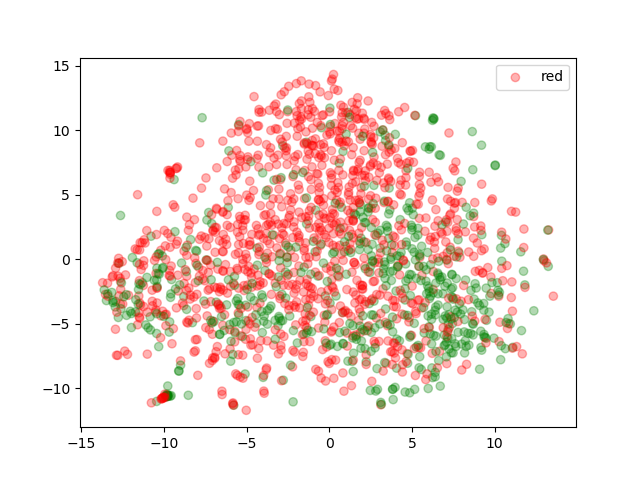

In [69]:
%matplotlib notebook

colors = ['red', 'green']

plt.scatter(
    x=[data[0] for data in reduced],
    y=[data[1] for data in reduced],
    c=[colors[int(data)] for data in df_data['night_label'].values],
    alpha = 0.3
)
plt.legend(colors)
plt.savefig('full-standarized-day-night.png')
plt.show()

In [ ]:
df_data.head()

In [ ]:
# Import dependencies
import plotly
import plotly.graph_objs as go

colors = ['red', 'green', 'blue', 'yellow']

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

colors = [data for data in df_data['night_label'].values]
# Configure the trace.
trace = go.Scatter3d(
    x=[data[0] for data in reduced],  # <-- Put your data instead
    y=[data[1] for data in reduced],  # <-- Put your data instead
    z=[data[2] for data in reduced],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 10,
        'opacity': 0.8,
        'color': colors
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

# MFCC

This block assumes that we have data in <code>df_data</code> variable.

In [ ]:
import librosa
import librosa.display

data_mfcc_labeled = []
night_timestamps = df_data.between_time("23:00", "3:30").index.values.tolist()
night_timestamps = pd.to_datetime(night_timestamps)

In [ ]:
df_data_labeled = df_data

In [ ]:
df_data_labeled.head()

In [ ]:
df_data_labeled['labeled'] = [int(index in night_timestamps) for index in df_data.index.values]

In [ ]:
for index, row in tqdm(df_data.iterrows(), total=df_data.shape[0]):
    full_mfccs = librosa.feature.mfcc(y=row['samples'], sr=3000, n_fft=512, hop_length=256, n_mfcc=14)
    data_mfcc_labeled.append([np.mean(full_mfccs,axis=1), row['temperature'], row['humidity'],
                              int(index in night_timestamps)])

# AUTOENCODER - BASIC

In [ ]:
import torch
import torch.nn as nn
import torch.utils.data as utils
import numpy as np
import pandas as pd

from tqdm import tqdm

In [ ]:
DATA_INIT = True
import glob 

auto_hives = [1300001, 1300002, 1400001, 1400002]
if DATA_INIT:
    auto_max_sample_value = 0
    auto_hive_sounds = []
    auto_hive_timestamps = []
    for idx, hive_id in enumerate(auto_hives):
        print(f"Data preparation for hive: {hive_id}")

        auto_sound_files = [f for f in glob.glob(f"measurements\\{hive_id}\\sound*.csv")]
        auto_sound_hive_list = []
        for file in tqdm(auto_sound_files):
            df_samples = pd.read_csv(file)
            pd_timestamp = pd.to_datetime(file.split("sound-")[1].split(".csv")[0], format='%Y-%m-%dT%H-%M-%S')
            if(len(df_samples.index) == 3000 and max(df_samples['samples'].values) < 4500):
                np_samples = np.array(df_samples['samples'].values, dtype="float32")
                np_samples = np_samples / 4080
                auto_hive_sounds.append([pd_timestamp, np_samples])
    np.random.shuffle(auto_hive_sounds)
    sound_pd = pd.DataFrame(auto_hive_sounds, columns=['timestamp', 'samples'])
    auto_df_data = sound_pd.set_index('timestamp')
    auto_df_data = sound_pd
else:
    sound_pd = np.load(f"{hives_ids[0]}-data.npy", allow_pickle=True)
    print(f"Loaded dataset with size {len(hive_sounds)}.")

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'We are running on : {device}')

num_epochs = 10
learning_rate = 1e-5
BATCH_SIZE = 30

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3000, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256)
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2048),
            nn.ReLU(True),
            nn.Linear(2048, 3000), nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
tensor_data = torch.FloatTensor([auto_df_data['samples'].values])
tensor_data.shape

In [ ]:
model = autoencoder()
model.to(device)

losses = []

def train(net):
    criterion = nn.MSELoss(reduction='sum')
    optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    
    for epoch in range(num_epochs):
        train_loss = 0
        for i in tqdm(range(0, tensor_data.size()[1], BATCH_SIZE)):
            batch_X = tensor_data[:, i:i+BATCH_SIZE, :]
            batch_X = batch_X.to(device)

            net.zero_grad()
            
            output = net(batch_X)
            loss = criterion(output, batch_X)
            loss.backward()
            optimizer.step()
    
            train_loss += loss.item()
        # ===================log========================
        loss_per_epoch = train_loss/tensor_data.size()[1]
        print(f"epoch [{epoch}/{num_epochs}], loss:{loss_per_epoch}")
        losses.append(loss_per_epoch)

In [ ]:
train(model)

In [ ]:
%matplotlib notebook  
import matplotlib.pyplot as plt


plt.plot(losses)
plt.title("Autoencoder loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'autoencoder-06-11-2019-model.pth')

In [ ]:
sound_tensors = torch.FloatTensor([df_data_labeled['samples'].values])

In [ ]:
sss = list(zip(sound_tensors, df_data_labeled['labeled'].values))

In [ ]:
with torch.no_grad():
    sound_tensors = sound_tensors.to(device)
    output = model.encoder(sound_tensors)
    output = output.squeeze(0)

In [ ]:
output.shape

In [ ]:
output_cpu = output.cpu()

In [ ]:
labels_list_val = df_data_labeled['labeled'].values

In [ ]:
len(labels)

# Basic classification PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
#standarized_mfcc_avg = StandardScaler().fit_transform([data[0] for data in data_mfcc_labeled])
#standarized_temp = StandardScaler().fit_transform([[data[1]] for data in data_mfcc_labeled])
#standarized_hum = StandardScaler().fit_transform([[data[2]] for data in data_mfcc_labeled])

standarized_autoencoder = StandardScaler().fit_transform(output.cpu())

#zipped_data = list(zip(standarized_mfcc_avg, standarized_temp, standarized_hum))
#merged_data = [np.concatenate(list_to_con) for list_to_con in zipped_data]
#standarized_merged_data = StandardScaler().fit_transform(merged_data)

pca = PCA(n_components=2)
pc_data = pca.fit_transform(standarized_autoencoder)

# Basic classification t-sne

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(output_cpu)

# Visualize

In [ ]:
len(pc_data[0])

In [ ]:
#pc_data_labeled = list(zip(pc_data, [mfcc_data[3] for mfcc_data in data_mfcc_labeled]))
colors = ['red', 'green', 'blue', 'yellow']
labels = ['day', 'night']

fig = plt.figure()

ax = fig.add_subplot(1, 1, 1)

# ax.scatter(x=[data[0][0] for data in pc_data_labeled],
#            y=[data[0][1] for data in pc_data_labeled],
#            c=[colors[int(data[1])] for data in pc_data_labeled],
#           alpha=0.3) 
ax.scatter(x=[data[0] for data in pc_data],
           y=[data[1] for data in pc_data],
           #c=[colors[data] for data in labels_list_val],
          alpha=0.3)
ax.legend()

plt.title("Autoencoder scatter plot")
plt.show()

### Evaluation

In [ ]:
model.load_state_dict(torch.load('autoencoder-06-11-2019-model.pth'))
model.to(device)

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='mnist', train=True,
                                   download=False, transform=transform)
test_data = datasets.MNIST(root='mnist', train=False,
                                  download=False, transform=transform)

# Create training and test dataloaders

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        ## encoder ##
        # linear layer (784 -> encoding_dim)
        self.fc1 = nn.Linear(28 * 28, encoding_dim)
        
        ## decoder ##
        # linear layer (encoding_dim -> input size)
        self.fc2 = nn.Linear(encoding_dim, 28*28)
        

    def forward(self, x):
        # add layer, with relu activation function
        x = F.relu(self.fc1(x))
        # output layer (sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.fc2(x))
        return x

# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim).to(device)
print(model)

# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# number of epochs to train the model
n_epochs = 20


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1).to(device)
        print(images.shape)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        print(images.size(0))
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))